# Polynomial minimization

This examples shows how to solve a constrained polynomial minimization problem. Given p(x) and g(x), consider the problem in `x`

    min  p(x)
    s.t. g(x) >= 0
    
We can lower bound the optimal value by solving the following problem in `gamma, sigma(x)`

    max  gamma
    s.t. p(x) - gamma - sigma(x) g(x) >= 0                (1)
         sigma(x) >= 0

In [1]:
import numpy as np
import scipy.sparse as sp
from sympy.abc import x, y
from posipoly.polynomial import Polynomial

tot_deg = 6        # overall degree of problem
n = 2              # number of variables
pp_cone = 'psd'    # can be 'psd' or 'sdd'

p = Polynomial.from_sympy(-x**2 - y**2 + x, [x,y])
g = Polynomial.from_sympy(1 - x**2 - y**2, [x,y])

We introduce a dummy variable `pos(x)` and replace positivity by cone constraints.
    
    max  gamma
    s.t. p(x) - gamma - sigma(x) g(x) = pos(x)                (2)
         sigma(x) SOS/SDSOS
         pos(x)   SOS/SDSOS

Let `S1_mat` be the gram matrix representation of `pos(x)`, i.e. `pos(x) = Z(x)' S1_mat Z(x)` and consider the variable vector `x = [gamma_coef sigma_mat S1_mat]`. We can write (2) in coefficient representation as

    max   c' * x
    s.t.  [I_cc    T_cg   I_cg] * x = p_c
          sigma_mat psd/sdd
          S1_mat    psd/sdd
          
where `I_cc` is the coef -> coef identity transformation, `T_cg` is the gram -> coef "times g" transformation, and `I_cg` is the gram -> coef identity transformation. We can extract these matrices from `PolyLinTrans` objects.

In [2]:
from posipoly.polylintrans import PolyLinTrans
from posipoly.ppp import solve_ppp

sigma_deg = tot_deg - g.d   # degree of sigma

A_gamma = PolyLinTrans.eye(1, n, 0, tot_deg).as_Tcc()     # coefs to coefs
A_sigma = PolyLinTrans.mul_pol(n, sigma_deg, g).as_Tcg()  # gram to coefs
A_S1 = PolyLinTrans.eye(n, n, tot_deg).as_Tcg()           # gram to coefs

n_gamma = A_gamma.shape[1]
n_sigma = A_sigma.shape[1]
n_S1 = A_S1.shape[1]

# Set up optimization problem on standard form
#   min  c' x   
#   s.t. Aeq x = beq
#        x[s,s+l] in pp_cone for s,l in ppp_list
#
#  where x[s,s+l] is a gram matrix in compact vector form

c = np.zeros(n_gamma+n_sigma+n_S1)
c[0] = -1

Aeq = sp.bmat([[A_gamma, A_sigma, A_S1]])
beq = p.mon_coefs(tot_deg)

ppp_list = [ [n_gamma, n_sigma], [n_gamma+n_sigma, n_S1] ]

# Solve problem and extract solution
sol, status = solve_ppp(c, Aeq, beq, None, None, ppp_list, pp_cone) 
opt_gamma = sol[0]

print('a lower bound is {:.2f}'.format(opt_gamma))

a lower bound is -2.00


<IPython.core.display.Javascript object>


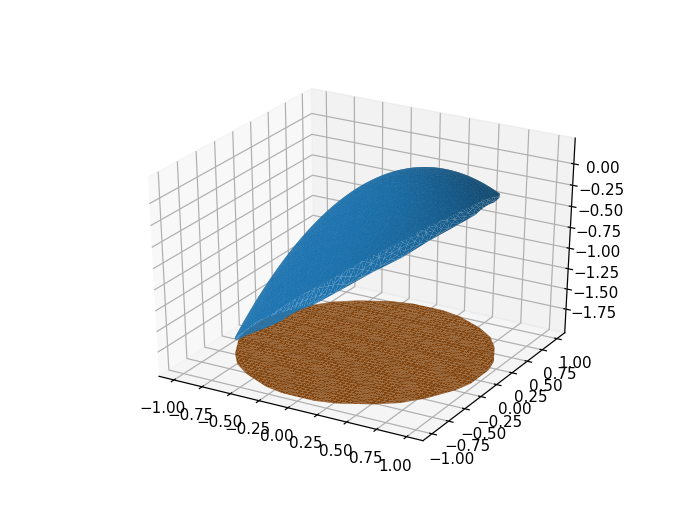

In [3]:
# plot polynomial for comparison
%matplotlib notebook
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

XX, YY = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
XX = XX.flatten()
YY = YY.flatten()

VV = np.vectorize(p.evaluate)(XX, YY)
VV_control = opt_gamma * np.ones(VV.shape)

mask = np.vectorize(g.evaluate)(XX, YY) >= 0

ax = plt.figure().gca(projection='3d')
ax.plot_trisurf(XX[mask], YY[mask], VV[mask])
ax.plot_trisurf(XX[mask], YY[mask], VV_control[mask])

plt.show()